<a href="https://colab.research.google.com/github/Alephaz9111/Neural-Networks/blob/master/GenerativeModel/GAN/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import (Dataset, DataLoader, TensorDataset)
import tqdm

In [2]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision

In [ ]:
#Oxford-102 dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
!tar xf 102flowers.tgz

!mkdir oxford-102
!mkdir oxford-102/jpg

!mv jpg/*.jpg oxford-102/jpg

--2020-09-02 06:43:13--  http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 344862509 (329M) [application/x-gzip]
Saving to: ‘102flowers.tgz’

102flowers.tgz      100%[===================>] 328.89M  32.2MB/s    in 11s     

2020-09-02 06:43:24 (30.2 MB/s) - ‘102flowers.tgz’ saved [344862509/344862509]



In [ ]:
#Oxford-102 dataset
img_data = ImageFolder("oxford-102/", 
                       transform=transforms.Compose([
                            transforms.Resize(80),
                            transforms.CenterCrop(64),
                            transforms.ToTensor()               
]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size, shuffle=True)

In [3]:
#CIFAR-10
!wget http://pjreddie.com/media/files/cifar.tgz
!tar xzf cifar.tgz

--2020-09-03 05:30:02--  http://pjreddie.com/media/files/cifar.tgz
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/cifar.tgz [following]
--2020-09-03 05:30:03--  https://pjreddie.com/media/files/cifar.tgz
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168584360 (161M) [application/octet-stream]
Saving to: ‘cifar.tgz’

cifar.tgz           100%[===================>] 160.77M   524KB/s    in 4m 11s  

2020-09-03 05:34:15 (655 KB/s) - ‘cifar.tgz’ saved [168584360/168584360]



In [4]:
#CIFAR-10
!mkdir CIFAR10
!mkdir CIFAR10/png

In [5]:
!mv cifar/train/*_airplane.png CIFAR10/png

In [6]:
#The number of Files
import os  

path = 'CIFAR10/png/'  
files = os.listdir(path)  
count = len(files)  
print(count)  

5000


In [7]:
#CIFAR-10
img_data = ImageFolder("CIFAR10/", 
                       transform=transforms.Compose([
                            transforms.Resize(80),
                            transforms.CenterCrop(64),
                            transforms.ToTensor()               
]))

batch_size = 64
img_loader = DataLoader(img_data, batch_size=batch_size, shuffle=True)

In [8]:
nz = 100
ngf = 32

class GNet(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.main = nn.Sequential(
        nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(ngf, 3, 4, 2, 1, bias=False),
        nn.Tanh()
    )

  def forward(self, x) :
    out = self.main(x)
    return out

In [9]:
ndf = 32

class DNet(nn.Module) :
  def __init__(self) :
    super().__init__()
    self.main = nn.Sequential(
        nn.Conv2d(3, ndf, 4, 2, 1, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
    )

  def forward(self, x) :
    out = self.main(x)
    return out.squeeze()

In [10]:
d = DNet().to("cuda:0")
g = GNet().to("cuda:0")

opt_d = optim.Adam(d.parameters(), lr=0.0002, betas=(0.5, 0.999))
opt_g = optim.Adam(g.parameters(), lr=0.0002, betas=(0.5, 0.999))

#CrossEntropy
ones = torch.ones(batch_size).to("cuda:0")
zeros = torch.zeros(batch_size).to("cuda:0")
loss_f = nn.BCEWithLogitsLoss()

#"z" for monitoring
fixed_z = torch.randn(batch_size, nz, 1, 1).to("cuda:0")

In [11]:
from statistics import mean

def train_dcgan(g, d, opt_g, opt_d, loader) :
  log_loss_g = []
  log_loss_d = []
  for real_img, _ in tqdm.tqdm(loader) :
    batch_len = len(real_img)

    #Copy real images to GPU
    real_img = real_img.to("cuda:0")

    #random number and real images
    z = torch.randn(batch_len, nz, 1, 1).to("cuda:0")
    fake_img = g(z)

    fake_img_tensor = fake_img.detach()

    #Calculate evaluational function for generation model
    out = d(fake_img)
    loss_g = loss_f(out, ones[: batch_len])
    log_loss_g.append(loss_g.item())

    #Renew parameter and calculate grad
    d.zero_grad(), g.zero_grad()
    loss_g.backward()
    opt_g.step()

    #Calculate evaluational function for discrimination model against real image
    real_out = d(real_img)
    loss_d_real = loss_f(real_out, ones[: batch_len])

    fake_img = fake_img_tensor

    #Calculate evaluational function for discrimination model against fake image
    fake_out = d(fake_img_tensor)
    loss_d_fake = loss_f(fake_out, zeros[: batch_len])

    loss_d = loss_d_real + loss_d_fake
    log_loss_d.append(loss_d.item())

    #Renew parameter and calculate grad
    d.zero_grad(), g.zero_grad()
    loss_d.backward()
    opt_d.step()

  return mean(log_loss_g), mean(log_loss_d)

In [12]:
!mkdir gene
!mkdir disc
!mkdir zzzz

In [ ]:
#Oxford-102
from torchvision.utils import save_image

for epoch in range(300) :
  train_dcgan(g, d, opt_g, opt_d, img_loader)
  if epoch % 10 == 0 :
    #Save parameter
    torch.save(
        g.state_dict(),
        "gene/g_{:03d}.prm".format(epoch),
        pickle_protocol=4
    )
    torch.save(
        d.state_dict(),
        "disc/d_{:03d}.prm".format(epoch),
        pickle_protocol=4
    )
    #Save images generated from z
    generated_img = g(fixed_z)
    save_image(generated_img, "zzzz/{:03d}.jpg".format(epoch))

100%|██████████| 128/128 [00:54<00:00,  2.33it/s]


In [13]:
#CIFAR-10
from torchvision.utils import save_image

for epoch in range(1000) :
  train_dcgan(g, d, opt_g, opt_d, img_loader)
  if epoch % 10 == 0 :
    #Save parameter
    torch.save(
        g.state_dict(),
        "gene/g_{:03d}.prm".format(epoch),
        pickle_protocol=4
    )
    torch.save(
        d.state_dict(),
        "disc/d_{:03d}.prm".format(epoch),
        pickle_protocol=4
    )
    #Save images generated from z
    generated_png = g(fixed_z)
    save_image(generated_png, "zzzz/{:03d}.png".format(epoch))

100%|██████████| 79/79 [00:04<00:00, 19.10it/s]


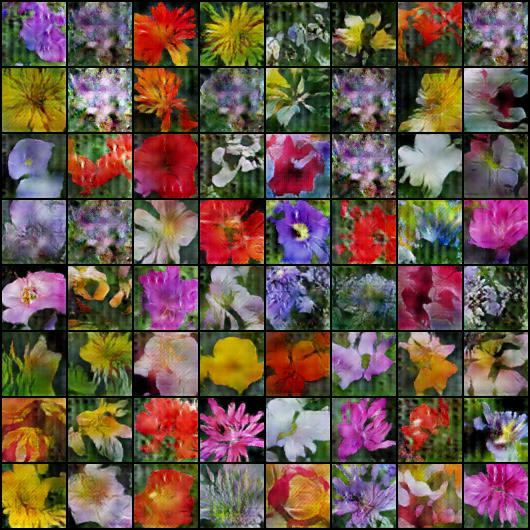

In [ ]:
#Oxford-102
from IPython.display import Image, display_jpeg
display_jpeg(Image('zzzz/290.jpg'))

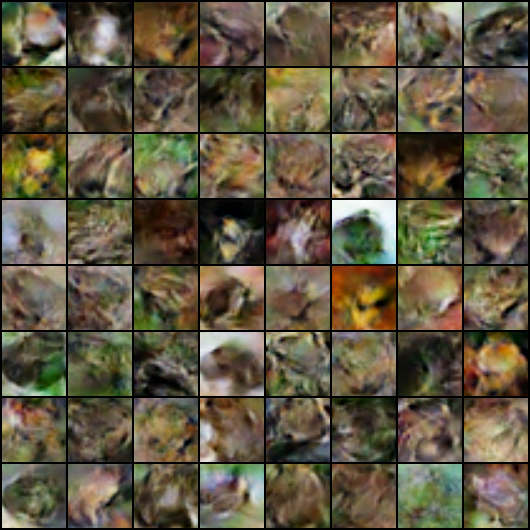

In [ ]:
#CIFAR-10
from IPython.display import Image
Image('zzzz/990.png')

In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [14]:
!zip -r /content/download0.zip /content/zzzz

from google.colab import files
files.download("/content/download0.zip")

  adding: content/zzzz/ (stored 0%)
  adding: content/zzzz/170.png (deflated 0%)
  adding: content/zzzz/950.png (deflated 0%)
  adding: content/zzzz/700.png (deflated 0%)
  adding: content/zzzz/560.png (deflated 0%)
  adding: content/zzzz/590.png (deflated 0%)
  adding: content/zzzz/420.png (deflated 0%)
  adding: content/zzzz/090.png (deflated 0%)
  adding: content/zzzz/400.png (deflated 0%)
  adding: content/zzzz/010.png (deflated 0%)
  adding: content/zzzz/870.png (deflated 0%)
  adding: content/zzzz/160.png (deflated 0%)
  adding: content/zzzz/350.png (deflated 0%)
  adding: content/zzzz/830.png (deflated 0%)
  adding: content/zzzz/940.png (deflated 0%)
  adding: content/zzzz/310.png (deflated 0%)
  adding: content/zzzz/040.png (deflated 0%)
  adding: content/zzzz/460.png (deflated 0%)
  adding: content/zzzz/440.png (deflated 0%)
  adding: content/zzzz/900.png (deflated 0%)
  adding: content/zzzz/070.png (deflated 0%)
  adding: content/zzzz/000.png (deflated 0%)
  adding: content/z

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>